<a href="https://colab.research.google.com/github/DOCgould/Chaotic-Hopfield-Neural-Network-Cryptographic-Encoder/blob/main/Demos/TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook will connect to a GPU, and then run the process of setting up, then permuting the Simplical Map Network we have created. 

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

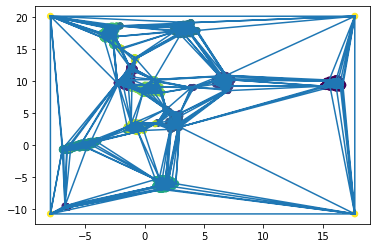

AttributeError: ignored

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.experimental.numpy as np
import numpy as np2
import timeit
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.datasets import load_digits


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    digits = load_digits()

    X = np2.loadtxt("embedding_digits.txt")
    p1 = [np2.max(X[:,0])+1,np2.max(X[:,1])+1]
    p2 = [np2.max(X[:,0])+1,np2.min(X[:,1])-1]
    p3 = [np2.min(X[:,0])-1,np2.min(X[:,1])-1]
    p4 = [np2.min(X[:,0])-1,np2.max(X[:,1])+1]


    X=np2.concatenate((X,np2.array([p1,p2,p3,p4])))
    y=np2.concatenate((digits.target,np2.array([10,10,10,10])))

    dataset = (
        X,
        y
    )

    data = dataset[0]
    classes = dataset[1]

    k = Delaunay(data)
    plt.triplot(data[:, 0], data[:, 1], k.simplices)
    plt.scatter(data[:, 0], data[:, 1], c=classes)
    plt.show()

    print(nn(dataset,[[15,9]]))
    print(nn(dataset,[X[1]]))

    return tf.math.reduce_sum(net_gpu)




def barycentric(delaunay, points, k):  # k=id simplice
    n = len(points[0])
    b = delaunay.transform[k, :n].dot(
        np2.transpose(points - delaunay.transform[k, n])
    )
    return np.c_[np.transpose(b), 1 - b.sum(axis=0)]


def cartesian(delaunay, barycentric, k):
    return barycentric.dot(delaunay.points[delaunay.simplices[k]])

def nn(dataset,p):
    """
    Desceription:
        An Algorithm that produces the Face of the Simplex

    """
    # the points
    data = dataset[0]

    # the classes
    classes = dataset[1]

    # the k-complex
    k = Delaunay(data)

    
    n = len(set(classes))

    c = np.zeros(n)

    # the l-complex

    #l = Delaunay(np.array([[0,0],[0,1],[1,0]]))
    ls = []

    d=np2.diag(np2.ones(n))

    ls.append(np2.zeros(n))

    for i in range(n):
        ls.append(d[i])
    l = Delaunay(ls) 

    # the barycentric subdivisions of the points p in K
    b=barycentric(k,p,k.find_simplex(p)[0])

    image = classes[k.simplices[k.find_simplex(p)]][0]

    # We take the baricentric subdivisions with respect to one of the simplices
    # to which p belongs to positive barycentric coordinates
    # cartesian picture of p in l

    f=b.dot(l.points[image])
    return  barycentric(l,f,0) # BARICÉNTRICAS DE P EN L
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))